# Elasticidade de preço - Sales:

### Objetivos:
- Quantificar a elasticidade-preço por produto, região e segmento de clientes.
- Identificar produtos com elasticidade baixa e alta.
- Criar modelo preditivo que estime a demanda em função do preço.
- Avaliar impacto financeiro esperado para diferentes estratégias de precificação.
- Sugerir ações para aumentar o ticket médio e faturamento com base no modelo.

---
Para esse projeto vou utilizar a seguinte estrutura:

1. Definição do problema (Pode ser encontrada no ReadMe)
2. Coletar dados e gerar uma visão geral
3. Dividir em treinamento e teste
4. EDA - Analise exploratória de dados
5. Feature engineering, limpeza e pré processamento.
6. Treinamento de modelo e feature selection.
7. Produção final do modelo, avaliação e testes.
8. Conclusão e interpretar resultados.
9. Deploy e implementação
---
*Ao final de cada bloco vou trazer meus insights e minhas decisões*

---
### Estrutura do Dataset:
| Coluna        | Descrição                                                           |
|---------------|---------------------------------------------------------------------|
| Sales Person  | *Nome do vendedor responsável pela transação*                       |
| Country	      | *Região de vendas ou localização da loja onde a transação ocorreu*  |
| Product       | *Nome do produto de chocolate vendido*                              |
| Date          | *A data da transação da venda de chocolate*                         |
| Amount        | *Receita total gerada a partir da venda.*                           |
| Boxes Shipped | *Número de caixas de chocolate enviadas na ordem.*              |



### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from elasticidadepreco.outliers import outliersCalc
from elasticidadepreco.elasticidade import elasticidade
from sklearn.preprocessing import StandardScaler
from elasticidadepreco.graphics import categoricalDistri
from elasticidadepreco.graphics import numericalDistri
from elasticidadepreco.graphics import bivariate_analysis
import warnings

from elasticidadepreco.serializador import inSerializer

# sns.set_palette("dark:#5A9_r")

warnings.filterwarnings('ignore')

### Entendendo os dados

link dataset:https://www.kaggle.com/datasets/atharvasoundankar/chocolate-sales?select=Chocolate+Sales.csv

In [2]:
df = pd.read_csv('../data/raw/Chocolate Sales.csv', encoding='utf-8')

In [3]:
df.head()

,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,04-Jan-22,"$5,320",180
1,Van Tuxwell,India,85% Dark Bars,01-Aug-22,"$7,896",94
2,Gigi Bohling,India,Peanut Butter Cubes,07-Jul-22,"$4,501",91
3,Jan Morforth,Australia,Peanut Butter Cubes,27-Apr-22,"$12,726",342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,24-Feb-22,"$13,685",184


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sales Person   1094 non-null   object
 1   Country        1094 non-null   object
 2   Product        1094 non-null   object
 3   Date           1094 non-null   object
 4   Amount         1094 non-null   object
 5   Boxes Shipped  1094 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 51.4+ KB


In [5]:
print(f'{df.shape[0]} linhas  \n{df.shape[1]} colunas')

1094 linhas  
6 colunas


In [6]:
df.isnull().sum()

Sales Person     0
Country          0
Product          0
Date             0
Amount           0
Boxes Shipped    0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df = df.rename(columns={
    'Sales Person': 'sales_person',
    'Country': 'country',
    'Product': 'product',
    'Date': 'date',
    'Amount': 'amount',
    'Boxes Shipped': 'boxes_shipped',
})

In [9]:
df['amount'] = df['amount'].str.replace('[\$,]', '', regex=True).str.strip().astype(int)

In [10]:
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y')

Insights:
- Alterei o nome de colunas para um formato mais amigavel
- Alterei os tipos para facilitar os processos
- E limpei um pouco a variavel de amount e data, para gerar analises mais precisas

### Analise Exploratória de Dados - EDA

#### Univariada - Distribuições e features padrão

In [11]:
train = df.copy()

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sales_person   1094 non-null   object        
 1   country        1094 non-null   object        
 2   product        1094 non-null   object        
 3   date           1094 non-null   datetime64[ns]
 4   amount         1094 non-null   int32         
 5   boxes_shipped  1094 non-null   int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(3)
memory usage: 47.1+ KB


In [13]:
numeric_features = train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = train.select_dtypes(exclude=[np.number, np.datetime64]).columns.tolist()

In [14]:
for col in categorical_features:
    print(f'{col} valores únicos: {train[col].nunique()}')
    print('-' * 40)

sales_person valores únicos: 25
----------------------------------------
country valores únicos: 6
----------------------------------------
product valores únicos: 22
----------------------------------------


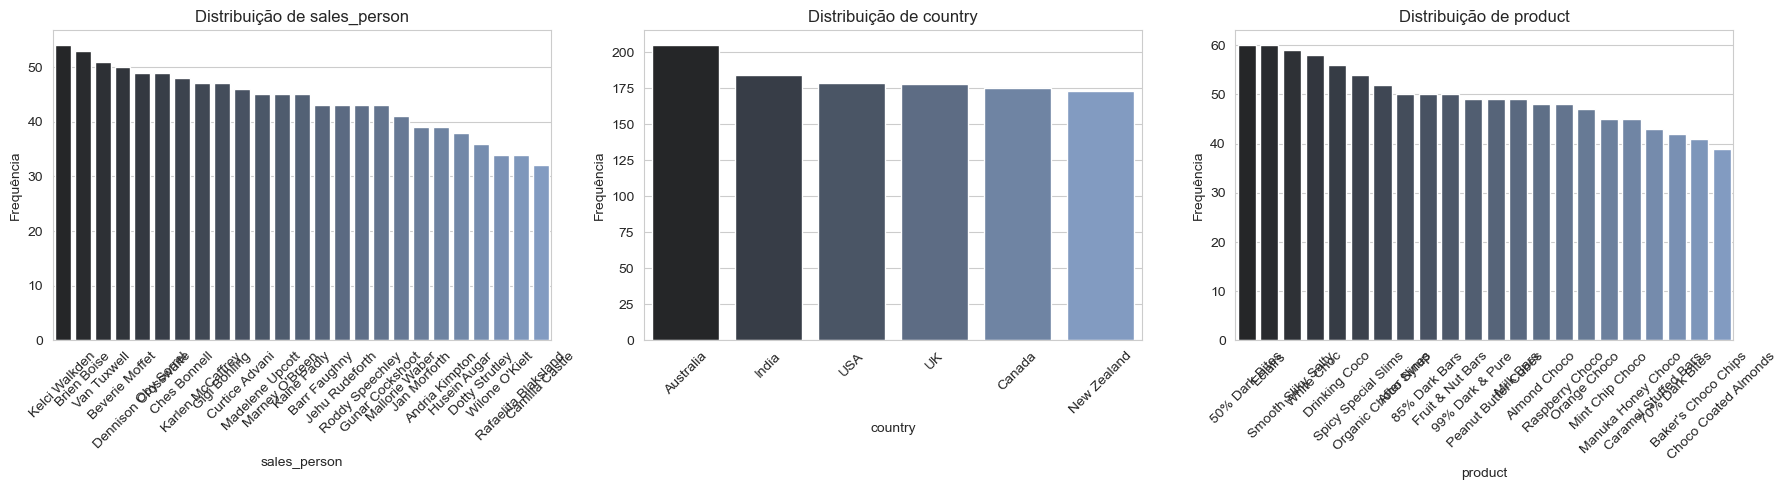

In [15]:
categoricalDistri(train, categorical_features)

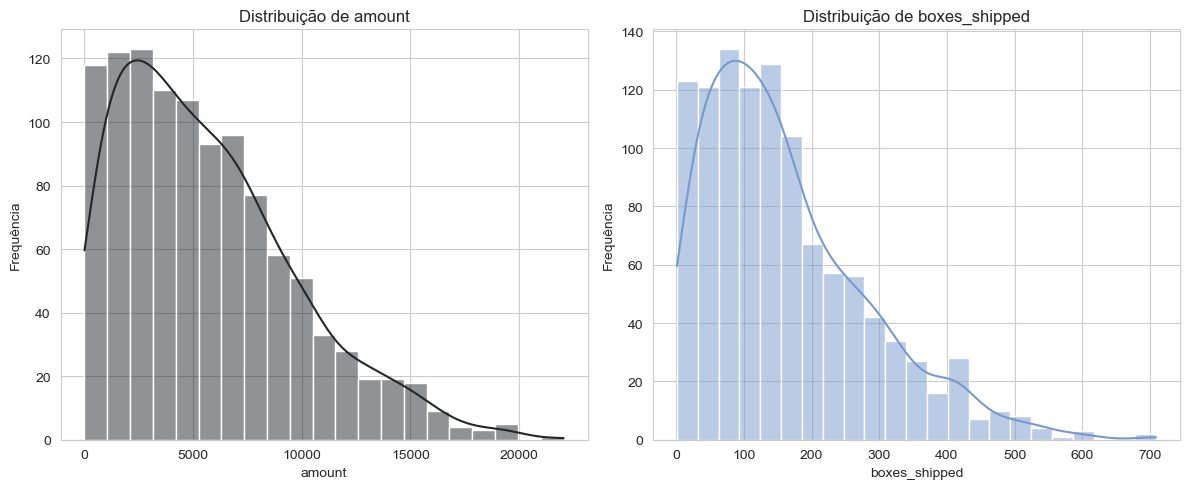

In [16]:
numericalDistri(train, numeric_features, 2)

Insights:

- country com 6 valores unicos, posso aplicar OneHot enconding
- 22 produtos diferentes cadastrados, e 25 vendedores
- Todos os vendedores realizaram mais que 20 ordens(vendas) durante o periodo do dataset, e todas as categorias de produtos estiveram em mais de 20 ordens também
- os paises tiveram uma semelhancia na quantia de ordens também, com destaque para Australia, que teve mais ordens de vendas durante o periodo
- Todos os paises tiveram mais que 120 ordens realizadas
- Vemos uma relação decrescente na distribuição da receita(amount), quando maior a receita (por ordem) menor foi a frequencia, ou quantia de ordens.Algo natural de se acontecer, maior o ticket por venda tende a ter poucas vendas com ticket alto ( pensamento de senso comum, poderia executar uma analise a respeito, porém fugiria do foco da analise)
- Semelhancia no grafico de caixas entregues, quanto maior é a quantidade de caixas entregues por ordem, menor é a quantidade de ordem. Um posicionamento também esperado, já que uma alta quantidade de caixas por pedido pode significar um amount alto também,(outra teoria baseado no senso comum)
- A semelhança entre os dois histogramas de amount e caixas entregues pode sugerir uma correlação entre essas features, isso será analisado mais a frente

#### Bivariada - Relações simples e Tratamento de Outliers

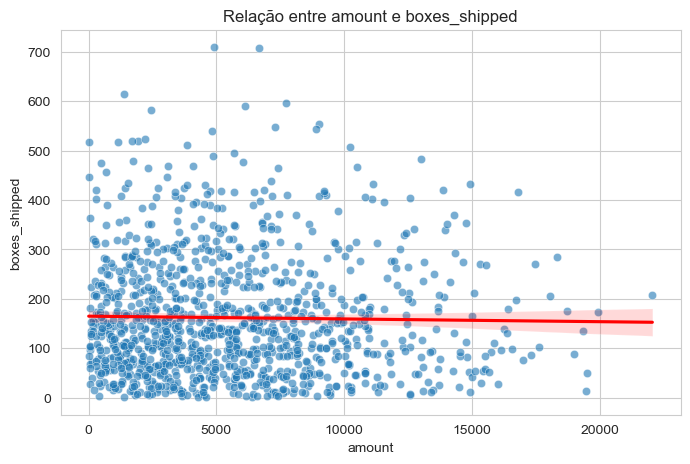

In [17]:
#NumXNum
bivariate_analysis(train, 'amount', 'boxes_shipped')

- Número de caixas entregues por receita
- Leve inclinação negativa da regressão linear, indicando possível correlação negativa, quando mais o amount aumenta o boxes_shipped tende a diminuir
- Muitos dados concentrados abaixo de 300 caixas entregues e com amount menor que 10000
- Linha de regressão(coeficiente) entre 100 a 200 caixas
- Acima de 300 caixas os dados ficam mais espalhados

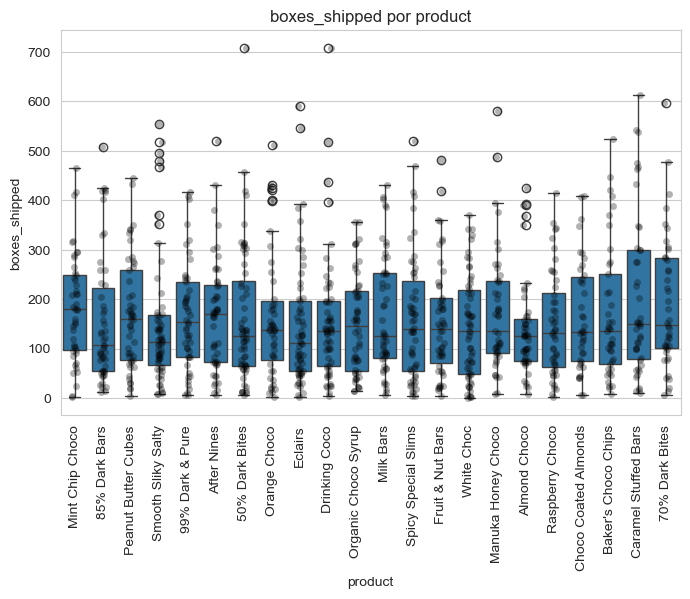

In [18]:
bivariate_analysis(train, 'product', 'boxes_shipped')

- Cada caixa repesenta o volume de caixas entregues por produto
- A maioria das medianas está abaixo de 200
- Caramel Stuffed Bars,Bakers Choco Chips possuem maior IQR, indicando maior variação típicas, ou seja, maior variação no volume de caixas entregues
- Almond Choco, Smoth Sliky Choco, 85% Dark Bars, possuem o menor IQR, indicando vendas mais concentradas, variando pouco o volume de caixas entregues
- Muitos limites superiores ultrapassando a marca de 300 boxes_shipped, indicando pedidos grandes, e em menor volume
- Maior concentração de outliers superiores acima de 400~500 caixas entregues, com destaque para 85% Dark Bars, um produto com vendas mais concentradas, indicando que possa ser ações promocionais
- Nehuma outliers inferiores, indicando que até com poucas caixas entregues existe um mínimo relevante no volume de vendas

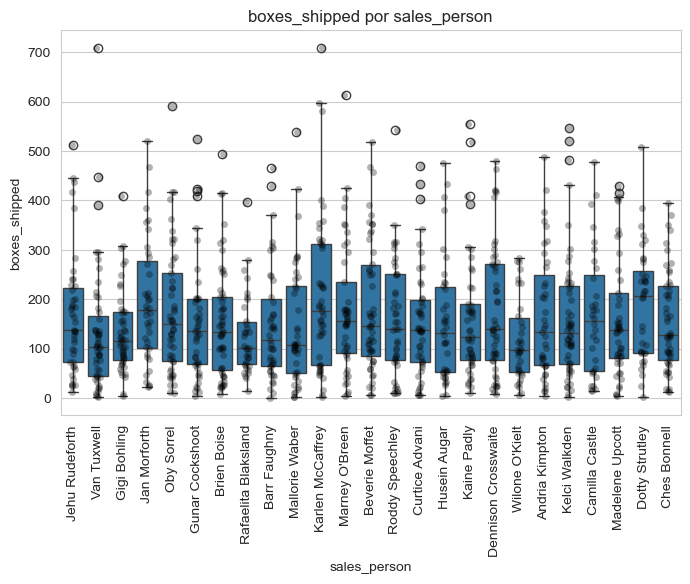

In [19]:
bivariate_analysis(train, 'sales_person', 'boxes_shipped')


- Medianas concentradas abaixo de 200 boxes_shipped
- Dennison C, Hussein A., Mallorie W, Andria Kimption com maior IQR, variação tipica, indicando variedade de volume em numero de caixas entregues
-  Em contrapartida, Gigi B., Wilone O., Jan M, com IQR mais contido, densidade no volume de caixas entregues, vendas mais concentradas
- Limite superior em maioria alcançando e até ultrapassando a marca de 400 boxes_shipped, indicando a presença de pedidos grandes com altos numeros de boxes_shipped
- presença de outlier acima de 400 caixas entregues e concentrados em Gunar C.,Curtice A., Brien B, Kelci W., Van Tuxwell e Madeline U.
- Destque para Dotty Strutley, com maior limite superior e sem outliers, mediana proxima do Q3, com os valores mais concentrados acima de 200 boxes_shipped, indicando ser um dos vendedores com maior variação de volume de caixas entregues, e sem outliers, ou seja sem picos disruptivos, mantendo certo padrão

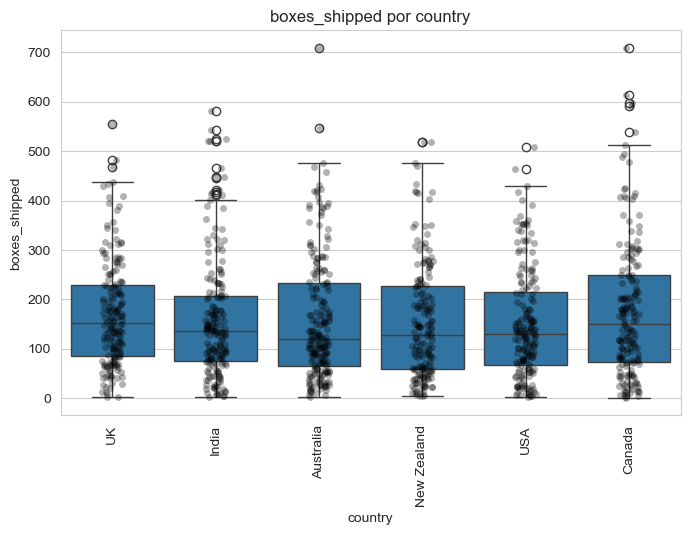

In [20]:
bivariate_analysis(train, 'boxes_shipped', 'country')

- Distribuição de caixas entregues por região/país
- Medianas abaixo de 200
- Canada com Maior IQR, mas não muito diferente(visualmente) dos demais, mas vale destacar essa variação no volume
- India com menor IQR, Q3 próximo de 200, mostrando ter certa condensamento na variação de caixas entregues, com vendas mais condensados
- Limite superior de 400 a acima de 500, no geral todos os países possuem vendas com alto número de caixas
- Presença de outliers acima de 400, com destaque para Canada com maior número

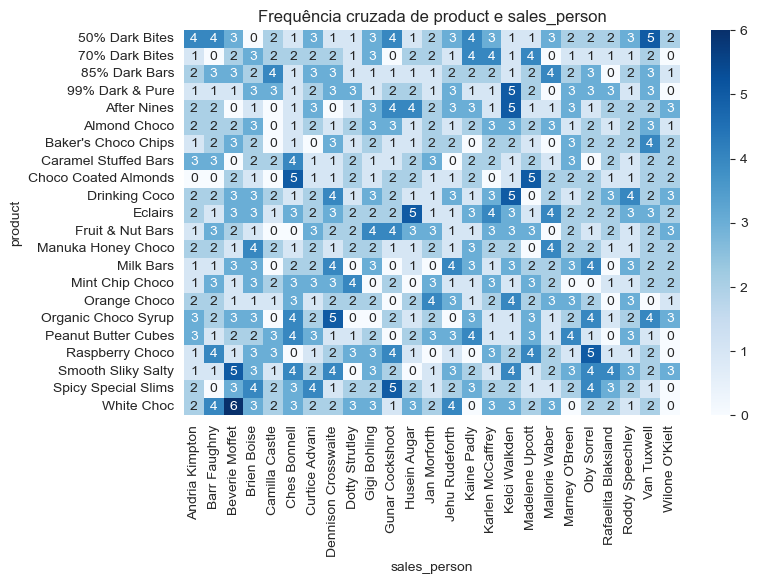

In [21]:
bivariate_analysis(train, 'product', 'sales_person')

- Maior frequência de vendas em: Beverie M. com White Choc,Ches B. com Choco Coated Almonds, Husein A. com Eclairs, e Kelci W. com After Nones e 99% Dark & Pure
- Produtos poucos vendidos: Milk Bars (maior numero de vendedores que não realizou nenhuma venda), Manuka Honey(quantidade de venda baixissima entre vendedores)
- Camila Castle com vendas menos diversificadas, focando no 85% Dark Bars e Raspberry Choco
- Outro destaque para Kelci W. sendo a única vendedora mais diversificada, vendendo pelo menos 1 unidade de cada produto do portfolio
- Choco Coated Almonds com uma possível dependência comercial, com maior frequência de vendas concentrada em Chess B. e em Madelene U.
- Destaque distribuição uniforme para Eclairs e Manuka Honey Choco, indicando uma possível venda fácil mas nem tão popular pela frequência de vendas por vendedor

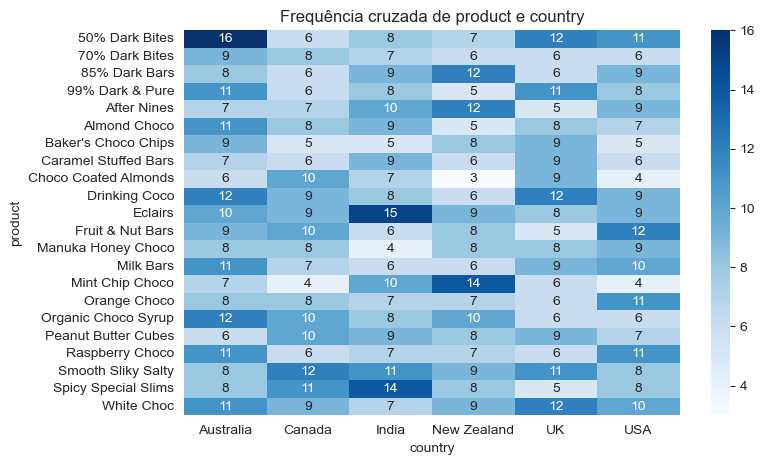

In [22]:
bivariate_analysis(train, 'product', 'country')

- Concentração de vendas de Eclairs e Spicy Special Slims na India, indicando possível risco comercial ou uma venda mais facil nessa região
- UK e Canada com maior uniformidade de vendas
- Choco Coated Almonds com menor frequência de vendas, indicando dificuldades no produto ou na aceitabilidade na maioria das regiões
- 50% Dark Bites,85% Dark Bars, 99% Dark & Pure, After Nines, Almond Choco, Caramel Stuffed BarsDrinking Coco, Eclairs, White Choc são produtos populares, estando presentes de forma singificante em todas as regiões (frequencia acima de 5)
- Tirando UK e Canada, as demais regiões apresentam uma uniformidade relativamente parecida de vendas

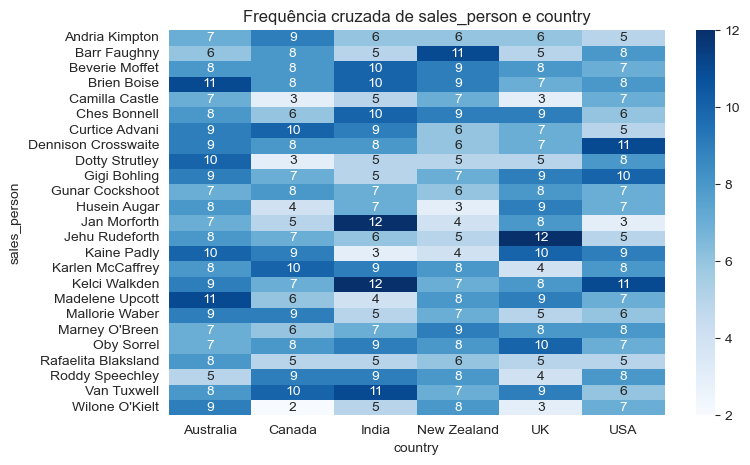

In [23]:
bivariate_analysis(train, 'sales_person', 'country')

- Destaque para Kelci W. e Van Tuxwell na India, Jehu R. na UK, e Kelci W. novamente em USA
- Camilla Castle com baixa frequencia de vendas por região, com regiões com poucos vendas
- Australia, USA e India são regiões com uniformidade na frequencia de vendas por vendedores
- Gunar Cockshoot e Curtice Advani são os vendedores com maior uniformidade nos dados, indicando uma facilidade de venda em multiregiões

In [24]:
#Outliers
outliers = outliersCalc(train[numeric_features])
outliers[numeric_features].sum() / len(train[numeric_features]) * 100

amount           1.462523
boxes_shipped    2.376600
dtype: float64

- Outliers menores que 3%
- Podem ser ações promocionais ou descontos

#### Multivariada - Enriquecimento de features + novos KPI´s

In [25]:
# calculado de elasticidade
train = elasticidade(train, 'boxes_shipped', 'amount')

In [26]:
#calculado de ticket medio
train['ticket'] = train['amount'] / train['boxes_shipped']

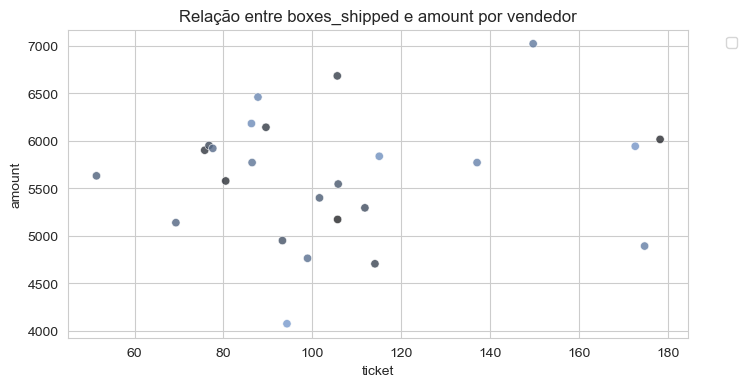

In [27]:
df_agg = train.groupby('sales_person').agg({
    'boxes_shipped': 'mean',
    'amount': 'mean',
    'ticket': 'mean',
}).reset_index()

palette = sns.dark_palette("#79C", n_colors=df_agg['sales_person'].nunique())

plt.figure(figsize=(8, 4))
sns.scatterplot(data=df_agg, x='ticket', y='amount', hue='sales_person',legend=False, palette=palette, alpha=0.8)
plt.title("Relação entre boxes_shipped e amount por vendedor")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [28]:
req = [
    (df_agg['amount'] <= 5500) & (df_agg['ticket'] <= 120),
    (df_agg['amount'] <= 5500) & (df_agg['ticket'] > 120),
    (df_agg['amount'] > 5500) & (df_agg['ticket'] <= 120),
    (df_agg['amount'] > 5500) & (df_agg['ticket'] > 120),
]

cat = [
    'baixo valor - baixo ticket',
    'baixo valor - alto ticket',
    'alto valor - baixo ticket',
    'alto valor - alto ticket'
]

df_agg['class_sales'] = np.select(req, cat, default=np.nan)

train = train.merge(df_agg[['sales_person', 'class_sales']], on='sales_person', how='left')

In [29]:
# Elasticidade por produto, região, segmento de vendedor
region = train.groupby('country')['elasticity'].mean().reset_index()
class_sales = train.groupby('class_sales')['elasticity'].mean().reset_index()
product_sales = train.groupby('product')['elasticity'].mean().reset_index()

Text(0.5, 1.0, 'Elasticidade média por país')

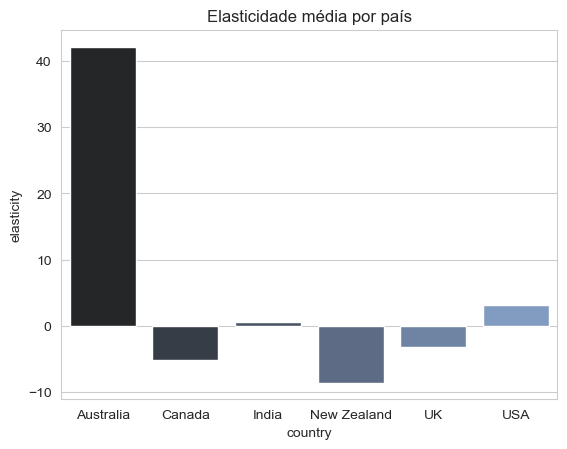

In [30]:
sns.barplot(x='country',y='elasticity',data=region,palette=sns.dark_palette("#79C"))
plt.title('Elasticidade média por país')

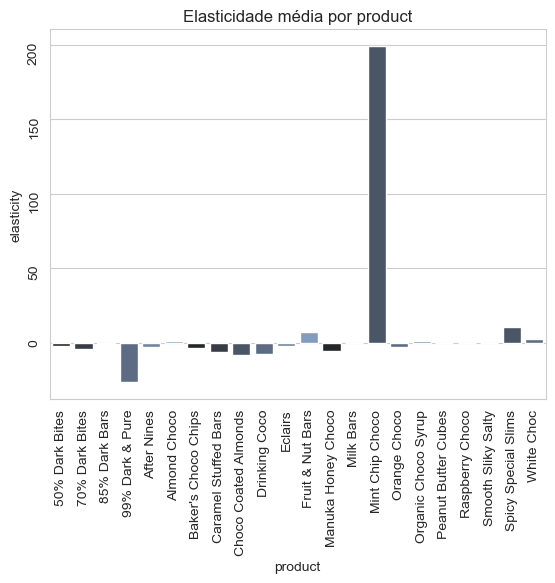

In [31]:
sns.barplot(x='product',y='elasticity',data=product_sales,palette=sns.dark_palette("#79C"))
plt.title('Elasticidade média por product')
plt.tick_params(rotation=90)

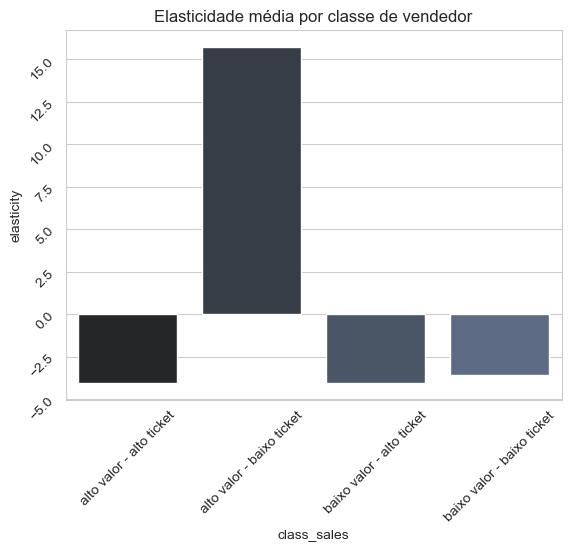

In [32]:
sns.barplot(x='class_sales',y='elasticity',data=class_sales,palette=sns.dark_palette("#79C"))
plt.title('Elasticidade média por classe de vendedor')
plt.tick_params(rotation=45)

In [33]:
#produtos com elasticidade baixa e alta
top10_product_upper = train.groupby('product')['elasticity'].mean().sort_values(ascending=False).head(10)
top10_product_lower = train.groupby('product')['elasticity'].mean().sort_values(ascending=True).head(10)

print('-' * 40)
print(f'Top produtos com maior Média de Elasticidade-preço :{top10_product_upper}')
print('-' * 40)
print(f'Top produtos com menor Média de Elasticidade-preço :{top10_product_lower}')


----------------------------------------
Top produtos com maior Média de Elasticidade-preço :product
Mint Chip Choco        199.061704
Spicy Special Slims     10.411816
Fruit & Nut Bars         6.801697
White Choc               2.606465
Organic Choco Syrup      1.210909
Almond Choco             1.141393
Raspberry Choco          0.025723
Smooth Sliky Salty      -0.300391
Peanut Butter Cubes     -0.428402
Milk Bars               -0.480138
Name: elasticity, dtype: float64
----------------------------------------
Top produtos com menor Média de Elasticidade-preço :product
99% Dark & Pure        -26.643364
Choco Coated Almonds    -8.429065
Drinking Coco           -7.442270
Caramel Stuffed Bars    -6.006615
Manuka Honey Choco      -5.689016
70% Dark Bites          -4.136571
Baker's Choco Chips     -3.576456
After Nines             -2.985580
Orange Choco            -2.789717
50% Dark Bites          -2.312622
Name: elasticity, dtype: float64


In [34]:
#segmentação de produtos premium
result = train.groupby('product').agg({
    'amount': 'sum',
    'elasticity': 'mean',

}).sort_values(by='elasticity', ascending=False).head(10)

result

,amount,elasticity
product,,
Mint Chip Choco,283969,199.061704
Spicy Special Slims,293454,10.411816
Fruit & Nut Bars,259147,6.801697
White Choc,329147,2.606465
Organic Choco Syrup,294700,1.210909
Almond Choco,277536,1.141393
Raspberry Choco,264740,0.025723
Smooth Sliky Salty,349692,-0.300391
Peanut Butter Cubes,324842,-0.428402


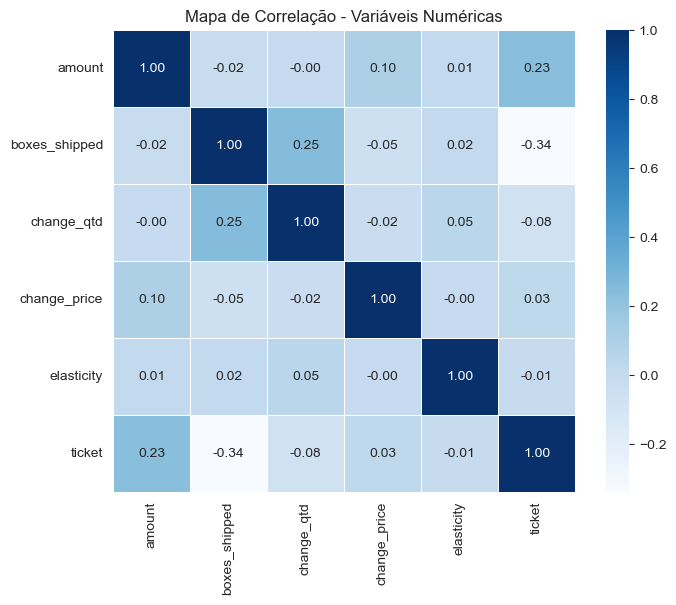

In [35]:
#correlação
plt.figure(figsize=(8,6))
sns.heatmap(
    data=train.select_dtypes(include=[np.number]).corr(),
    annot=True,           # mostra os valores na célula
    fmt=".2f",            # formato decimal
    cmap='Blues',      # paleta de cor bacana
    cbar=True,
    square=True,
    linewidths=0.5
)
plt.title('Mapa de Correlação - Variáveis Numéricas')
plt.show()

Insights:

- algo
- oi

#### Séries temporais e Sazonalidade

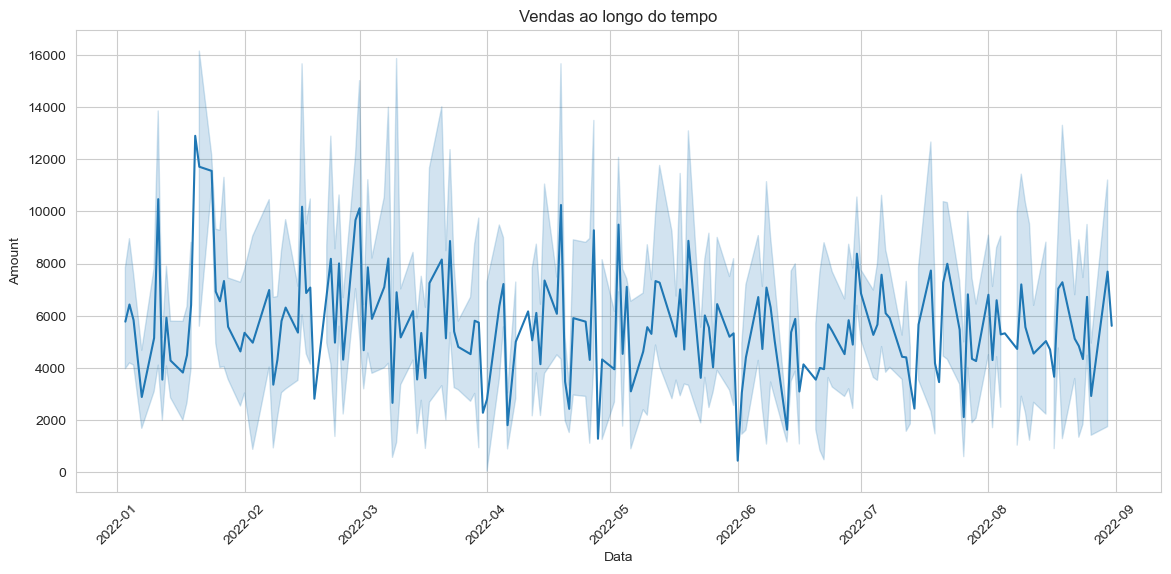

In [36]:
plt.figure(figsize=(14,6))
sns.lineplot(data=train, x='date', y='amount')
plt.title('Vendas ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.show()

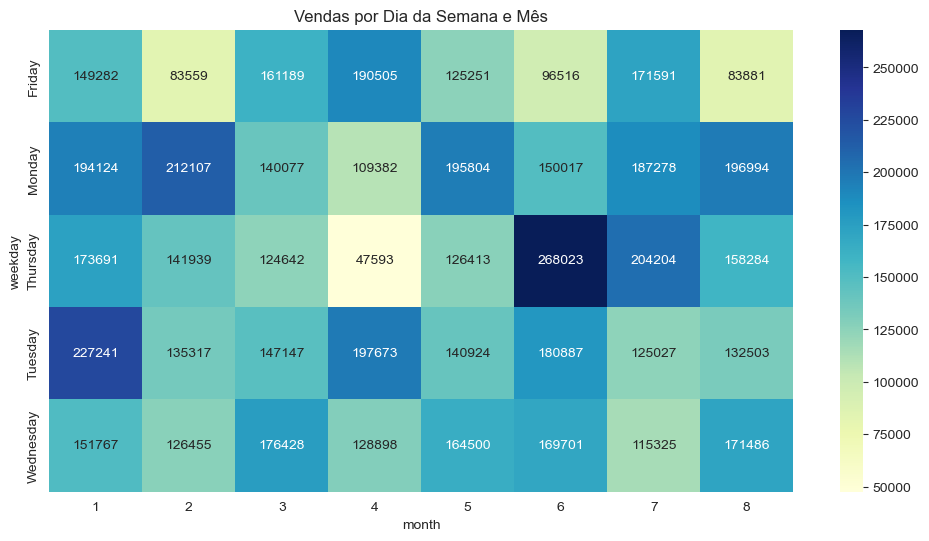

In [37]:
train['month'] = train['date'].dt.month
train['weekday'] = train['date'].dt.day_name()

pivot_table = train.pivot_table(index='weekday', columns='month', values='amount', aggfunc='sum')

plt.figure(figsize=(12,6))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".0f")
plt.title('Vendas por Dia da Semana e Mês')
plt.show()


### Insights e hipóteses -  Respondendo perguntas

### Para Modelagem

In [39]:
inSerializer(train,'../data/interim/preprocessado')

['../data/interim/preprocessado.joblib']